# Contextual Bandits Agent with Policy Gradient Method in Prediction Markets Problem
---
This is a program that simulates an agent who trades in a prediction market. The problem that the prediction market aims to solve is to predict the real distribution of a random variable. We define the random variable as the colour of a bucket. The problem design comes from a human-subjective experiment for decision markets.  

In [1]:
import numpy as np

import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import traceback
from scipy.special import expit

In [3]:
class PredictionMarket:
    n_outcomes = 0
    outcomes_list = []
    
    def __init__(self, outcomes_list):
        self.outcomes_list = outcomes_list.copy()
        self.n_outcomes = len(outcomes_list)
        self.init_prediction = np.ones(self.n_outcomes)/ self.n_outcomes
        self.current_prediction = self.init_prediction
        
    def report(self, prediction):
        assert len(prediction) == self.n_outcomes, 'Number of outcomes not fit!'
        assert sum(prediction) == 1, print('Probabilities not sum to one!', prediction)
        # Record the contract if multiple traders.
        self.current_prediction = prediction.copy()
        
    def log_resolve(self, materialised_index):
        assert materialised_index < self.n_outcomes, 'Index out of scope!'
        scores = np.log(self.current_prediction) - np.log(self.init_prediction)
        return scores[materialised_index]

In [4]:
class Bucket:
    
    def __init__(self, prior_red = 0.5):
        assert prior_red >= 0, 'Prior can not be negative!'
        assert prior_red <=1, 'Prior can not greater than one!'
        
        self.prior_red = prior_red
        self.colour = np.random.choice(['red_bucket', 'blue_bucket'], p=(self.prior_red, 1 - self.prior_red))
        if self.colour == 'red_bucket':
            self.ball_list = ['red', 'red', 'blue']
        else:
            self.ball_list = ['blue', 'blue', 'red']
    
    def signal(self):
        return np.random.choice(self.ball_list)

In [490]:
class Agent:
    
    def __init__(self, feature_shape, learn_rate, beta1 = 0.9, beta2 = 0.999, epsilon = 1e-8):
        self.w_mean = np.zeros(feature_shape)
        self.w_std = np.zeros(feature_shape)
        self.learn_rate = learn_rate
        self.reward_history = np.empty((1, 3))
        self.baseline = 0
        
        # Momentum variables
        self.beta1 = beta1
        self.v_dw_mean = np.zeros(feature_shape)
        self.v_dw_std = np.zeros(feature_shape)
        
        # RMSprop vaiables
        self.beta2 = beta2
        self.epsilon = epsilon
        self.s_dw_mean = np.zeros(feature_shape)
        self.s_dw_std = np.zeros(feature_shape)
        
    def sigmoid(self, preference):
        return 1/ (1 + np.exp(-preference))
    
    def gaussian(self, x, mu, sig):
        return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))
    
    def gradient_approx(self, features, epsilon = 1e-7):
        
        J_plus = np.zeros(self.w_mean.shape)
        J_minus = np.zeros(self.w_mean.shape)
        
        for i in range(J_plus.shape[1]):
            self.w_mean[:, i] += epsilon
            reports = self.report(features)
            J_plus[:, i] = (np.log(reports[0]) - np.log(0.5) )
            self.w_mean[:, i] -= epsilon
            
        for i in range(J_minus.shape[1]):
            self.w_mean[:, i] -= epsilon
            reports = self.report(features)
            J_minus[:, i] = (np.log(reports[0]) - np.log(0.5) )
            self.w_mean[:, i] += epsilon
    
        gradapprox = (J_plus - J_minus)/ (2*epsilon)

        return gradapprox
    
    def report(self, features):
        
        self.features = features
        
        self.means = np.inner(self.w_mean, features)
        self.stds = np.exp(np.inner(self.w_std, features))
        
        
        self.report_mean = np.mean(self.means)
        self.report_std = np.mean(self.stds)
        
            
        self.h = np.random.normal(self.report_mean, self.report_std)
        
        self.pi = self.sigmoid(self.h)
        
        if np.isnan(self.pi):
            print('h: ', self.h)
            print('report_mean:', self.report_mean)
            print('report_std:', self.report_std)
            print('means:', self.means)
            print('stds:', self.stds)
            print('features', features)
            raise AssertionError('Warning: report is None !!!')
        
        return [self.pi, 1 - self.pi]
    
    def __generate_log_policy_grad(self):
        gradient_mean = self.features *\
        ((self.h - self.report_mean)/ self.report_std**2) \
        * self.gaussian(self.h, self.report_mean, self.report_std) \
        * (1 - self.pi)
        
        gradient_std = self.features *\
        ((self.h - self.report_mean)**2 / self.report_std**2 - 1) \
        * self.gaussian(self.h, self.report_mean, self.report_std) \
        * (1 - self.pi)
        
#         if self.features[0, 1] == 1: # blue ball
#             gradient_mean *= 0.7
#             gradient_std *= 0.7
        
        return [gradient_mean, gradient_std]
    
    def __print_algorithm(self, t, algorithm):
        if t == 0:
            print('Updating weights with ' + algorithm + ' algorithm.')

        
    def update(self, rewards, t, algorithm = 'adam'):
        
        
#         Baseline term
        # Nonstationary tracking
        self.baseline = self.beta1 * self.baseline + (1 - self.beta1) * (rewards)
        # Stationary tracking
#         self.baseline = self.baseline + (1/ (t+1)) * (rewards - self.baseline)
        rewards_diff = rewards - self.baseline
            
        self.reward_history = np.r_[self.reward_history, np.array([[rewards, self.baseline, rewards_diff]])]
        
        gradient_mean, gradient_std = self.__generate_log_policy_grad()
            
        if algorithm == 'baseline':
            rewards_corrected = rewards_diff/ (1 - np.power(self.beta1, t + 1))
        else:
            rewards_corrected = rewards
            
        gradient_mean *= rewards_corrected
        gradient_std *= rewards_corrected
        
        # momentum update
        self.v_dw_mean = self.beta1 * self.v_dw_mean + (1 - self.beta1) * gradient_mean
        self.v_dw_std = self.beta1 * self.v_dw_std + (1 - self.beta1) * gradient_std
        
        # RMSprop update
        self.s_dw_mean = self.beta2 * self.s_dw_mean + (1 - self.beta2) * (np.power(gradient_mean, 2))
        self.s_dw_std = self.beta2 * self.s_dw_std + (1 - self.beta2) * (np.power(gradient_std, 2))
        
        # bias correction
        v_dw_mean_corrected = self.v_dw_mean/ (1 - np.power(self.beta1, t + 1))
        v_dw_std_corrected = self.v_dw_std/ (1 - np.power(self.beta1, t + 1))
        s_dw_mean_corrected = self.s_dw_mean/ (1 - np.power(self.beta2, t + 1))
        s_dw_std_corrected = self.s_dw_std/ (1 - np.power(self.beta2, t + 1))
        
        # Adam term
        adam_dw_mean_corrected = (v_dw_mean_corrected/ (np.sqrt(s_dw_mean_corrected) + self.epsilon) )
        adam_dw_std_corrected = (v_dw_std_corrected/ (np.sqrt(s_dw_std_corrected) + self.epsilon))        
        
        # Only update the corresponding weights
#         kernel = self.features
#         kernel[:, -1] = 1 
#         v_dw_mean_corrected = np.multiply(v_dw_mean_corrected, kernel)
#         v_dw_std_corrected = np.multiply(v_dw_std_corrected, kernel)
#         s_dw_mean_corrected = np.multiply(s_dw_mean_corrected, kernel)
#         s_dw_std_corrected = np.multiply(s_dw_std_corrected, kernel)     

        
        # update weights
        
        # Adam algorithm
        if algorithm == 'adam':
            self.w_mean += self.learn_rate * adam_dw_mean_corrected
            self.w_std += self.learn_rate * adam_dw_std_corrected
            self.__print_algorithm(t, algorithm)
            
        # Momentum algorithm
        elif algorithm == 'momentum':
            self.w_mean += self.learn_rate * v_dw_mean_corrected
            self.w_std += self.learn_rate * v_dw_std_corrected            
            self.__print_algorithm(t, algorithm)
        # Regular Update
        else:
            self.w_mean += self.learn_rate * gradient_mean
            self.w_std += self.learn_rate * gradient_std
            self.__print_algorithm(t, algorithm)
        
        return np.array([gradient_mean, gradient_std, v_dw_mean_corrected, v_dw_std_corrected, adam_dw_mean_corrected, adam_dw_std_corrected])

In [491]:
def OneHotEncode(feature):
    if feature == 'red':
        return np.array([[1, 0]])
    else:
        return np.array([[0, 1]])
    
bucket_colour_to_num = {'red_bucket': 0, 'blue_bucket': 1}

In [492]:
def gradient_check(agent):

    pm = PredictionMarket(outcomes_list=['red_bucket', 'blue_bucket'])
    x = np.array([[1, 0, 0.5]])
    report = agent.report(x)
    gradapprox = agent.gradient_approx(x)
    pm.report(report)
    R = pm.log_resolve(0)
    gradient_mean, gradient_std = agent.update(R)
    
    numerator = np.linalg.norm(gradient_mean - gradapprox)                                           # Step 1'
    denominator = np.linalg.norm(gradient_mean) + np.linalg.norm(gradapprox)                                         # Step 2'
    difference = numerator/denominator
    
    if difference > 2e-7:
        print ("\033[93m" + "There is a mistake in the backward propagation! difference = " + str(difference) + "\033[0m")
    else:
        print ("\033[92m" + "Your backward propagation works perfectly fine! difference = " + str(difference) + "\033[0m")
    
    return difference    

In [593]:
learning_rate = 0.001
training_episodes = 30000
beta1 = 0.9
beta2 = 0.9999
# Algorithm: adam, momentum, baseline, regular
algorithm = 'adam'

agent = Agent(feature_shape=[1, 3], learn_rate=learning_rate, beta1=beta1, beta2=beta2)


mean_weights_history = np.empty((1, 3))
std_weights_history = np.empty((1, 3))

r_ball_mean_history = []
b_ball_mean_history = []
r_ball_std_history = []
b_ball_std_history = []

r_ball_pred_history = []
b_ball_pred_history = []

grad_r_ball_mean_history = np.empty((1, 3))
grad_b_ball_mean_history = np.empty((1, 3))
grad_r_ball_std_history = np.empty((1, 3))
grad_b_ball_std_history = np.empty((1, 3))

grad_r_ball_v_mean_history = np.empty((1, 3))
grad_b_ball_v_mean_history = np.empty((1, 3))
grad_r_ball_v_std_history = np.empty((1, 3))
grad_b_ball_v_std_history = np.empty((1, 3))

grad_r_ball_adam_mean_history = np.empty((1, 3))
grad_b_ball_adam_mean_history = np.empty((1, 3))
grad_r_ball_adam_std_history = np.empty((1, 3))
grad_b_ball_adam_std_history = np.empty((1, 3))

record = []

for t in range(training_episodes):
    prior_red = 0.5
    bucket = Bucket(prior_red)
    pm = PredictionMarket(outcomes_list=['red_bucket', 'blue_bucket'])
    signal = bucket.signal()
    x = np.c_[OneHotEncode(signal), prior_red]
    report = agent.report(x)

    pm.report(report)
    R = pm.log_resolve(bucket_colour_to_num[bucket.colour])
    
    mean_weights_history = np.r_[mean_weights_history, agent.w_mean]
    std_weights_history = np.r_[std_weights_history, agent.w_std]
    
    try:
        grad_mean, grad_std, v_dw_mean_corrected, v_dw_std_corrected, \
        s_dw_mean_corrected, s_dw_std_corrected = agent.update(R, t, algorithm= algorithm)
    except AssertionError:
        tb = traceback.format_exc()
        print(tb)
        
    if signal == 'red':
        r_ball_pred_history.append(report[0])
        r_ball_mean_history.append(agent.report_mean)
        r_ball_std_history.append(agent.report_std)
        grad_r_ball_mean_history = np.r_[grad_r_ball_mean_history, grad_mean]
        grad_r_ball_std_history = np.r_[grad_r_ball_std_history, grad_std]
        ##########
        grad_r_ball_v_mean_history = np.r_[grad_r_ball_v_mean_history, v_dw_mean_corrected]
        grad_r_ball_v_std_history = np.r_[grad_r_ball_v_std_history, v_dw_std_corrected]
        grad_r_ball_adam_mean_history = np.r_[grad_r_ball_adam_mean_history, s_dw_mean_corrected]
        grad_r_ball_adam_std_history = np.r_[grad_r_ball_adam_std_history, s_dw_std_corrected]
       
    else:
        b_ball_pred_history.append(report[0])
        b_ball_mean_history.append(agent.report_mean)
        b_ball_std_history.append(agent.report_std)
        grad_b_ball_mean_history = np.r_[grad_b_ball_mean_history, grad_mean]
        grad_b_ball_std_history = np.r_[grad_b_ball_std_history, grad_std]
        #########
        grad_b_ball_v_mean_history = np.r_[grad_b_ball_v_mean_history, v_dw_mean_corrected]
        grad_b_ball_v_std_history = np.r_[grad_b_ball_v_std_history, v_dw_std_corrected]
        grad_b_ball_adam_mean_history = np.r_[grad_b_ball_adam_mean_history, s_dw_mean_corrected]
        grad_b_ball_adam_std_history = np.r_[grad_b_ball_adam_std_history, s_dw_std_corrected]
        
    record.append([agent.w_std[0, 0], agent.w_std[0, 1], grad_std[0, 0], grad_std[0, 1], v_dw_std_corrected[0, 0], v_dw_std_corrected[0, 1], R, signal])

Updating weights with adam algorithm.


In [594]:
# gradient_check(agent)

In [595]:
agent.stds

array([[0.01987005]])

In [596]:
agent.w_mean

array([[ 0.7094653 , -0.51218138,  0.01499624]])

In [597]:
agent.w_std

array([[-2.55963989, -2.27750087, -3.28203731]])

In [598]:
record_df = pd.DataFrame(record, columns=['red weight', 'blue weight', 'red gradient', 'blue gradient', 'red v', 'blue v', 'reward', 'signal'])

In [599]:
record_df

,red weight,blue weight,red gradient,blue gradient,red v,blue v,reward,signal
0,-0.001000,0.000000,-0.029953,-0.000000,-0.029953,0.000000,0.066152,red
1,-0.000591,0.000000,0.067609,0.000000,0.021395,0.000000,-0.210728,red
2,-0.000275,0.000639,0.000000,0.117960,0.013500,0.043528,-0.301478,blue
3,-0.000420,0.001162,-0.056189,-0.000000,-0.006764,0.030871,0.197146,red
4,-0.000161,0.001605,0.078788,0.000000,0.014127,0.023332,-0.157185,red
...,...,...,...,...,...,...,...,...
29995,-2.561153,-2.277681,0.134107,0.000000,0.019947,0.008556,-0.419536,red
29996,-2.560909,-2.277600,-0.065361,-0.000000,0.011416,0.007700,0.297780,red
29997,-2.560403,-2.277527,0.134443,0.000000,0.023719,0.006930,-0.422736,red
29998,-2.560001,-2.277461,-0.025390,-0.000000,0.018808,0.006237,0.291671,red


In [600]:
record_df.describe()

,red weight,blue weight,red gradient,blue gradient,red v,blue v,reward
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,-1.377455,-1.086549,-0.004071,-0.006223,-0.004075,-0.006220,0.033802
std,0.754128,0.683672,0.045623,0.087677,0.010339,0.020097,0.330064
min,-2.579842,-2.279593,-0.458270,-0.510081,-0.063444,-0.105184,-3.557144
25%,-1.979282,-1.658729,-0.012723,-0.016353,-0.010853,-0.019129,-0.296060
50%,-1.438553,-1.090596,0.000000,0.000000,-0.004124,-0.006192,0.216092
75%,-0.751237,-0.496230,0.000000,-0.000000,0.002643,0.006407,0.281306
max,0.016147,0.004790,0.181860,0.362965,0.038907,0.103669,0.670830


Text(0.5, 1.0, 'Rewards and Baseline')

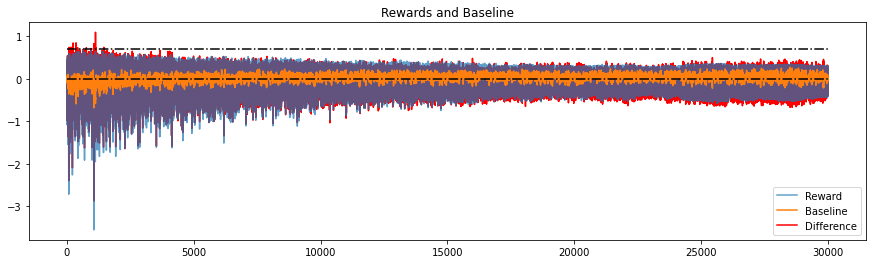

In [601]:
fig = plt.figure(figsize=(15, 4))
plt.plot(agent.reward_history[1:, 0], zorder = -100, label = 'Reward', alpha = 0.7)
plt.plot(agent.reward_history[1:, 1], zorder= -99, label = 'Baseline')
plt.plot(agent.reward_history[1:, 2], 'r', zorder= -101, label = 'Difference' )
plt.hlines(y=np.log(2), xmin=0, xmax=agent.reward_history.shape[0], colors='black', linestyles='dashdot')
plt.hlines(y=0.0, xmin=0, xmax=agent.reward_history.shape[0] , colors='black', linestyles='dashdot')
plt.legend()
plt.title('Rewards and Baseline')

15119


Text(0.5, 1.0, 'Report')

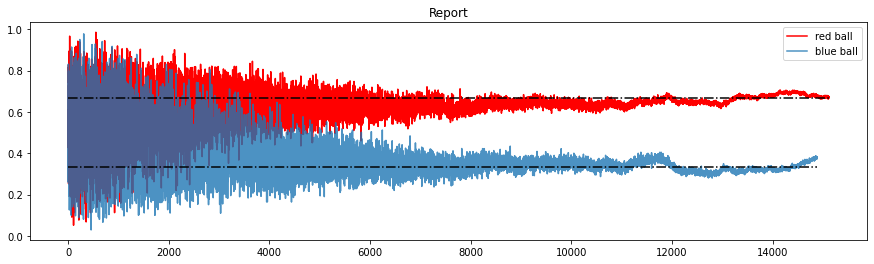

In [602]:
print(len(r_ball_pred_history))
fig = plt.figure(figsize=(15, 4))
plt.plot(r_ball_pred_history, 'r',zorder=-100, label='red ball')
plt.plot(b_ball_pred_history, zorder=-99, label = 'blue ball', alpha=0.8)
plt.hlines(y=2/3, xmin=0, xmax=len(r_ball_pred_history), colors='black', linestyles='dashdot')
plt.hlines(y=1/3, xmin=0, xmax=len(b_ball_pred_history) , colors='black', linestyles='dashdot')
plt.legend()
plt.title('Report')

In [579]:
print(agent.report([1, 0, 0.5]))

[0.5748349081309854, 0.42516509186901463]


In [580]:
print(agent.report([0, 1, 0.5]))

[0.18583071282261254, 0.8141692871773875]


Text(0.5, 1.0, 'Mean')

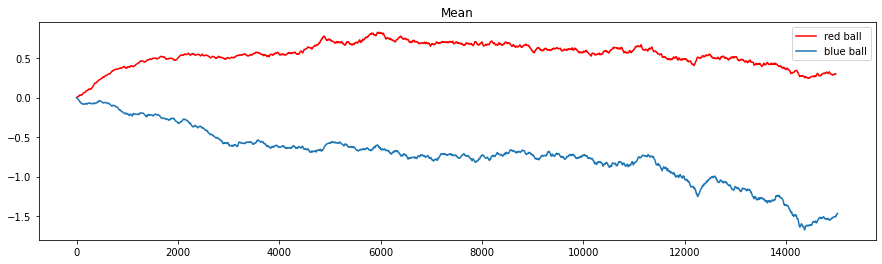

In [581]:
fig = plt.figure(figsize=(15, 4))
plt.plot(r_ball_mean_history, 'r', label = 'red ball')
plt.plot(b_ball_mean_history,label = 'blue ball')
plt.legend()
plt.title('Mean')

Text(0.5, 1.0, 'Weights for Mean')

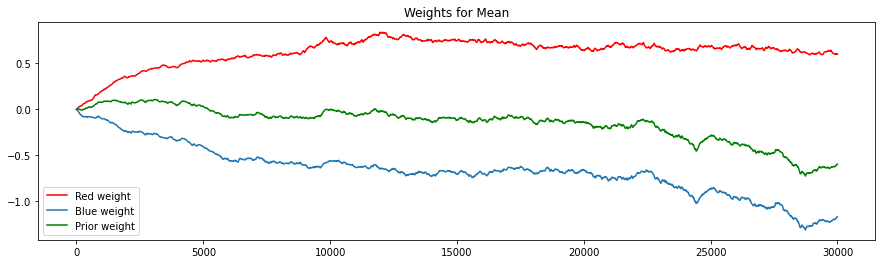

In [582]:
fig = plt.figure(figsize=(15, 4))
plt.plot(mean_weights_history[1:, 0], 'r', label='Red weight')
plt.plot(mean_weights_history[1:, 1], label='Blue weight')
plt.plot(mean_weights_history[1:, 2], 'g', label='Prior weight')
plt.legend()
plt.title('Weights for Mean')

Text(0.5, 1.0, 'Standard Diviation')

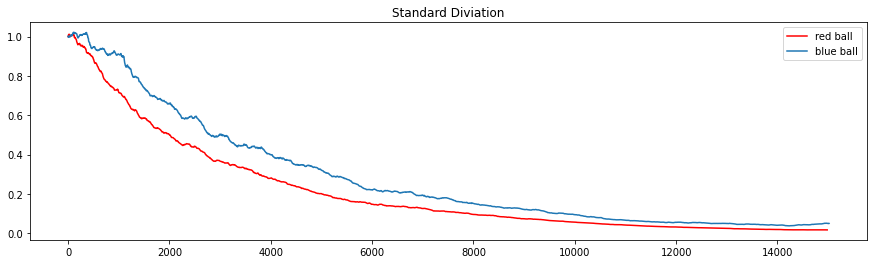

In [583]:
fig = plt.figure(figsize=(15, 4))
plt.plot(r_ball_std_history, 'r', label = 'red ball')
plt.plot(b_ball_std_history,label = 'blue ball')
plt.legend()
plt.title('Standard Diviation')

Text(0.5, 1.0, 'Weights for standard diviation')

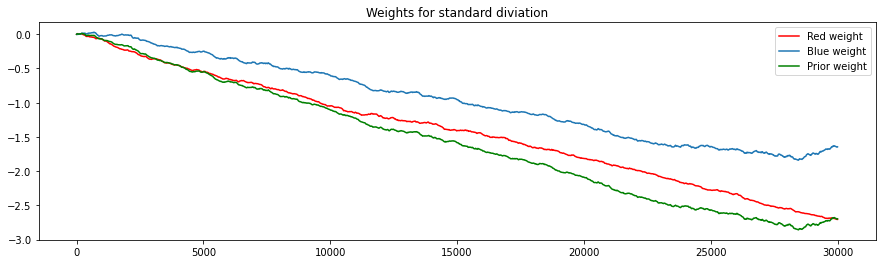

In [584]:
fig = plt.figure(figsize=(15, 4))
plt.plot(std_weights_history[1:, 0], 'r', label='Red weight')
plt.plot(std_weights_history[1:, 1], label='Blue weight')
plt.plot(std_weights_history[1:, 2], 'g', label='Prior weight')
plt.legend()
plt.title('Weights for standard diviation')

Text(0.5, 0.98, 'Signal Mean Gradients')

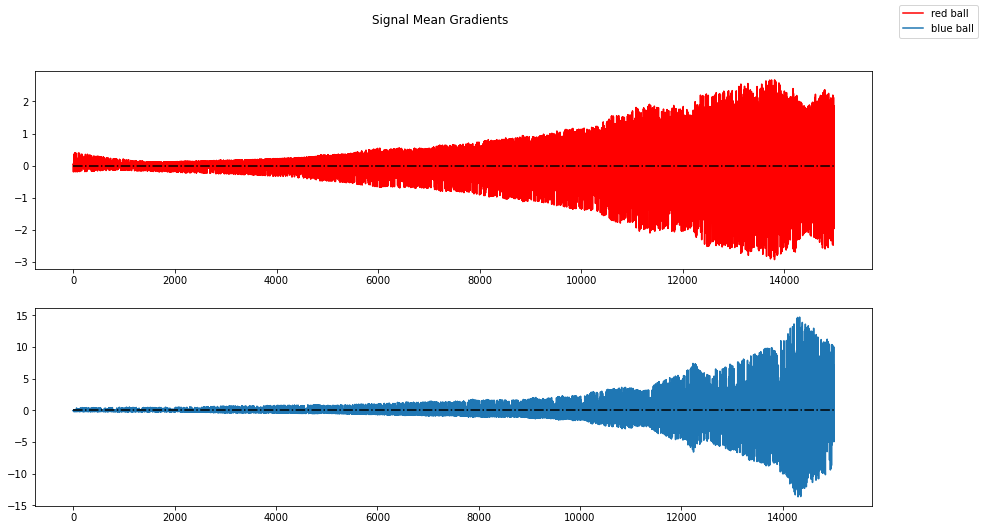

In [585]:
fig, axs = plt.subplots(2, figsize=(15, 8))
axs[0].plot(grad_r_ball_mean_history[1:, 0], 'r', label = 'red ball', zorder=-100)
axs[1].plot(grad_b_ball_mean_history[1:, 1],label = 'blue ball', zorder=-100)
axs[0].hlines(y=0, xmin=0, xmax=grad_r_ball_mean_history.shape[0], colors='black', linestyles='dashdot')
axs[1].hlines(y=0, xmin=0, xmax=grad_b_ball_mean_history.shape[0], colors='black', linestyles='dashdot')
fig.legend()
fig.suptitle('Signal Mean Gradients')

Text(0.5, 0.98, 'Signal Mean Gradients (momentum)')

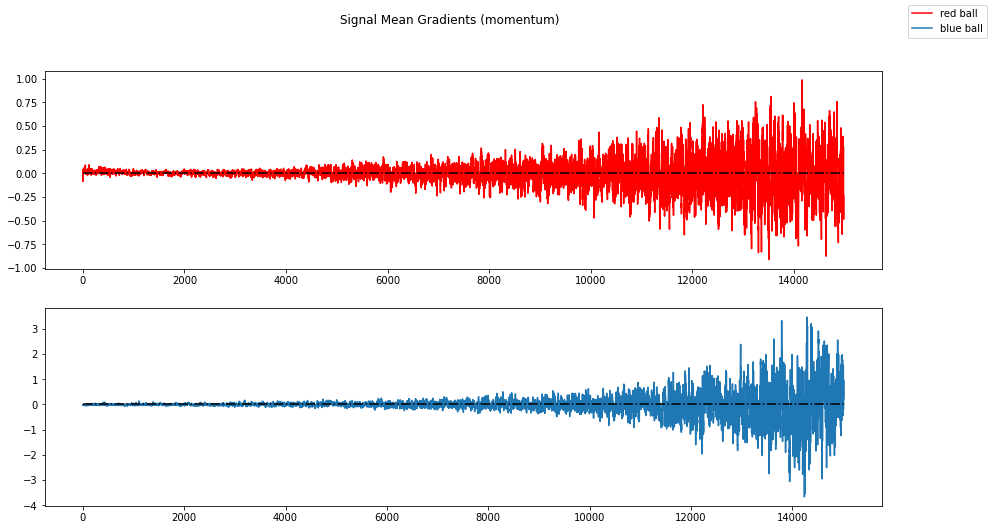

In [586]:
fig, axs = plt.subplots(2, figsize=(15, 8))
axs[0].plot(grad_r_ball_v_mean_history[1:, 0], 'r', label = 'red ball', zorder=-100)
axs[1].plot(grad_b_ball_v_mean_history[1:, 1],label = 'blue ball', zorder=-100)
axs[0].hlines(y=0, xmin=0, xmax=grad_r_ball_v_mean_history.shape[0], colors='black', linestyles='dashdot')
axs[1].hlines(y=0, xmin=0, xmax=grad_b_ball_v_mean_history.shape[0], colors='black', linestyles='dashdot')
fig.legend()
fig.suptitle('Signal Mean Gradients (momentum)')

Text(0.5, 0.98, 'Signal Mean Gradients (Adam)')

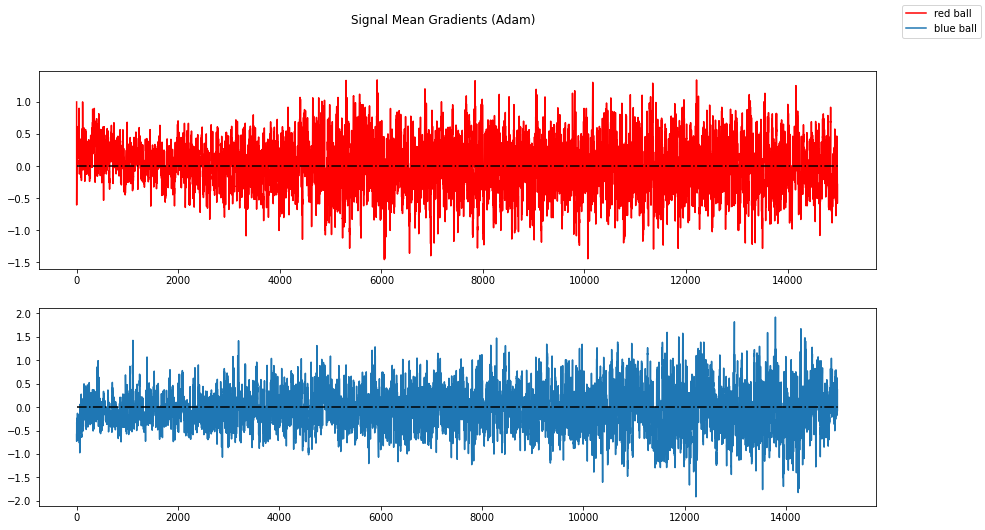

In [587]:
fig, axs = plt.subplots(2, figsize=(15, 8))
axs[0].plot(grad_r_ball_adam_mean_history[1:, 0], 'r', label = 'red ball', zorder=-100)
axs[1].plot(grad_b_ball_adam_mean_history[1:, 1],label = 'blue ball', zorder=-100)
axs[0].hlines(y=0, xmin=0, xmax=grad_r_ball_v_mean_history.shape[0], colors='black', linestyles='dashdot')
axs[1].hlines(y=0, xmin=0, xmax=grad_b_ball_v_mean_history.shape[0], colors='black', linestyles='dashdot')
fig.legend()
fig.suptitle('Signal Mean Gradients (Adam)')

Text(0.5, 0.98, 'Prior Mean Gradient')

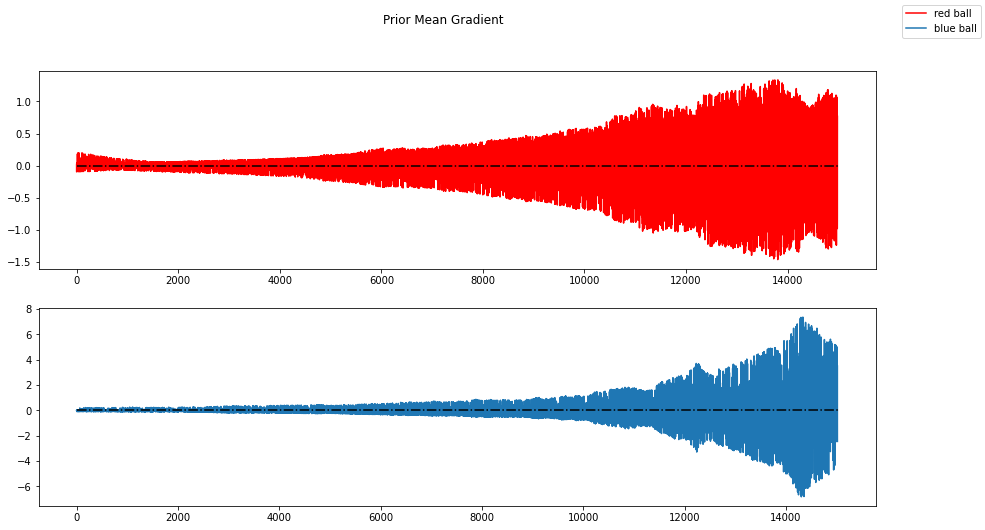

In [588]:
fig, axs = plt.subplots(2, figsize=(15, 8))
axs[0].plot(grad_r_ball_mean_history[1:, 2], 'r', label = 'red ball', zorder = -100)
axs[1].plot(grad_b_ball_mean_history[1:, 2],label = 'blue ball', zorder = -100)
axs[0].hlines(y=0, xmin=0, xmax=grad_r_ball_mean_history.shape[0], colors='black', linestyles='dashdot')
axs[1].hlines(y=0, xmin=0, xmax=grad_b_ball_mean_history.shape[0], colors='black', linestyles='dashdot')
fig.legend()
fig.suptitle('Prior Mean Gradient')

Text(0.5, 0.98, 'Prior Mean Gradient (Momentum)')

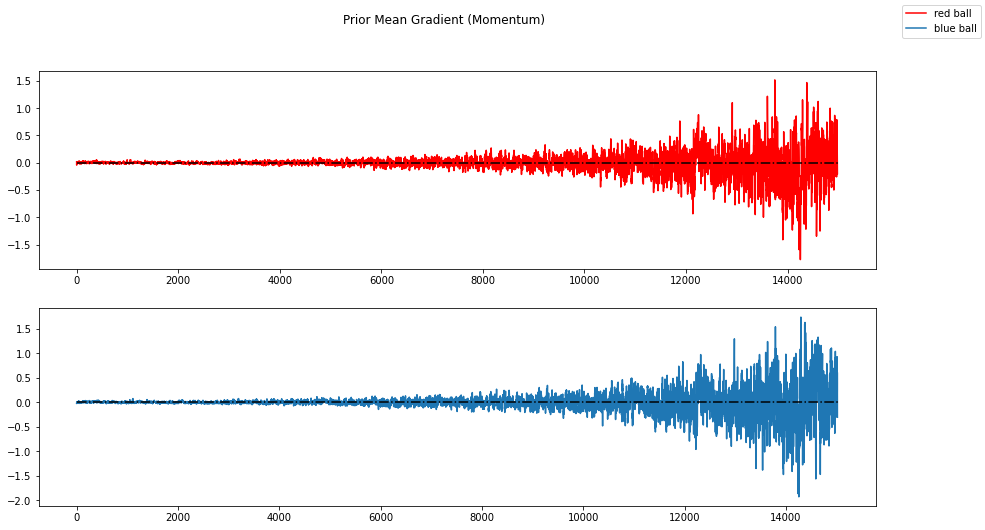

In [589]:
fig, axs = plt.subplots(2, figsize=(15, 8))
axs[0].plot(grad_r_ball_v_mean_history[1:, 2], 'r', label = 'red ball', zorder = -100)
axs[1].plot(grad_b_ball_v_mean_history[1:, 2],label = 'blue ball', zorder = -100)
axs[0].hlines(y=0, xmin=0, xmax=grad_r_ball_v_mean_history.shape[0], colors='black', linestyles='dashdot')
axs[1].hlines(y=0, xmin=0, xmax=grad_b_ball_v_mean_history.shape[0], colors='black', linestyles='dashdot')
fig.legend()
fig.suptitle('Prior Mean Gradient (Momentum)')

Text(0.5, 0.98, 'Signal Standard Diviation Gradient')

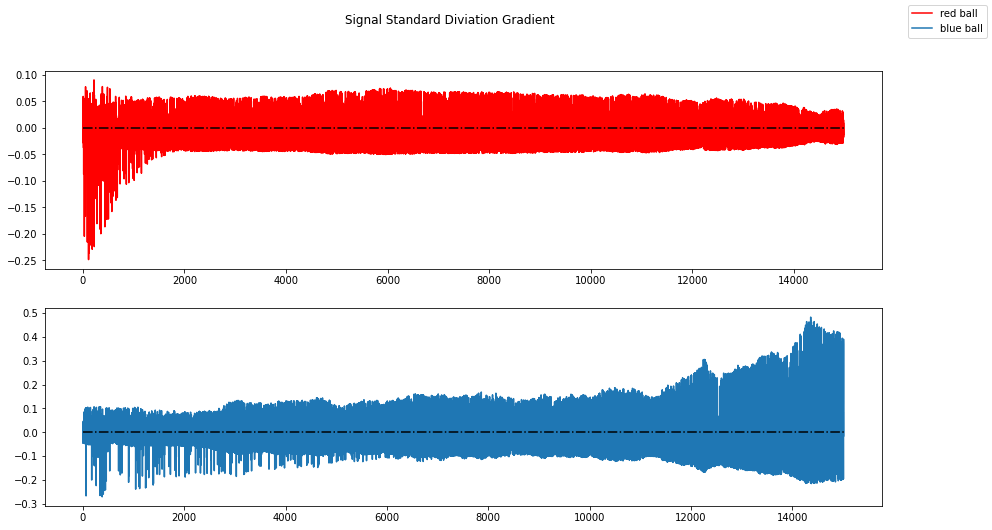

In [590]:
fig, axs = plt.subplots(2, figsize=(15, 8))
axs[0].plot(grad_r_ball_std_history[1:, 2], 'r', label = 'red ball', zorder = -100)
axs[1].plot(grad_b_ball_std_history[1:, 2],label = 'blue ball', zorder = -100)
axs[0].hlines(y=0, xmin=0, xmax=grad_r_ball_std_history.shape[0], colors='black', linestyles='dashdot')
axs[1].hlines(y=0, xmin=0, xmax=grad_b_ball_std_history.shape[0], colors='black', linestyles='dashdot')
fig.legend()
fig.suptitle('Signal Standard Diviation Gradient')

Text(0.5, 0.98, 'Signal Standard Diviation Gradient (Momentum)')

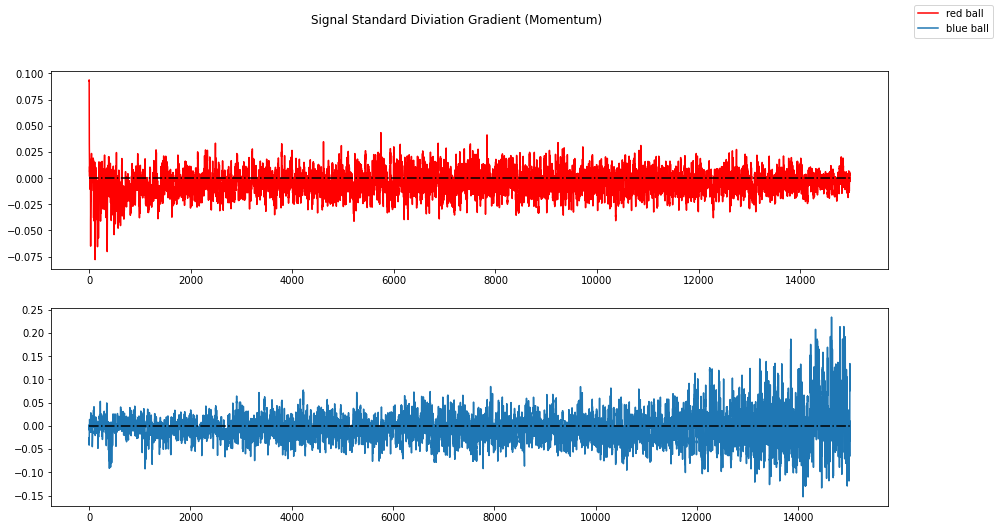

In [591]:
fig, axs = plt.subplots(2, figsize=(15, 8))
axs[0].plot(grad_r_ball_v_std_history[1:, 0], 'r', label = 'red ball', zorder = -100)
axs[1].plot(grad_b_ball_v_std_history[1:, 1],label = 'blue ball', zorder = -100)
axs[0].hlines(y=0, xmin=0, xmax=grad_r_ball_v_std_history.shape[0], colors='black', linestyles='dashdot')
axs[1].hlines(y=0, xmin=0, xmax=grad_b_ball_v_std_history.shape[0], colors='black', linestyles='dashdot')
fig.legend()
fig.suptitle('Signal Standard Diviation Gradient (Momentum)')

Text(0.5, 0.98, 'Signal Standard Diviation Gradient (Adam)')

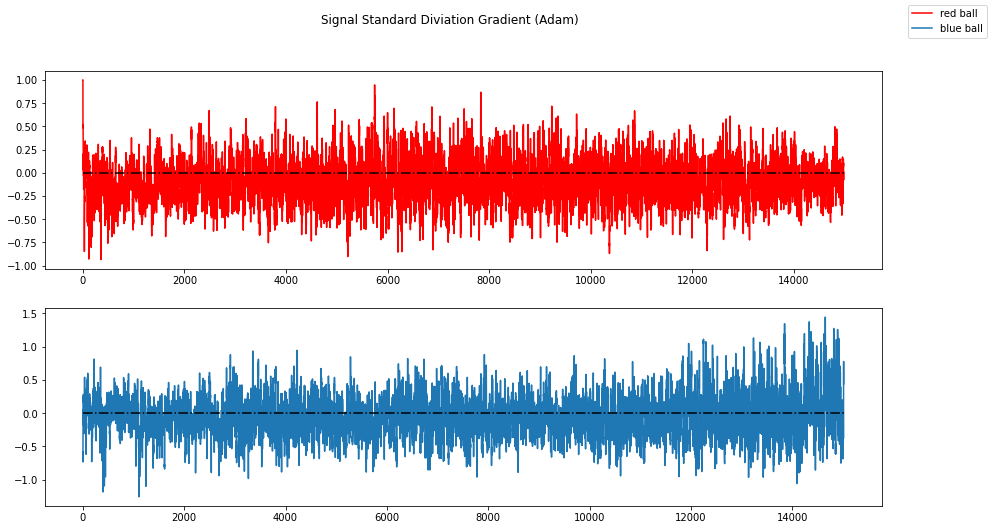

In [592]:
fig, axs = plt.subplots(2, figsize=(15, 8))
axs[0].plot(grad_r_ball_adam_std_history[1:, 0], 'r', label = 'red ball', zorder=-100)
axs[1].plot(grad_b_ball_adam_std_history[1:, 1],label = 'blue ball', zorder=-100)
axs[0].hlines(y=0, xmin=0, xmax=grad_r_ball_v_std_history.shape[0], colors='black', linestyles='dashdot')
axs[1].hlines(y=0, xmin=0, xmax=grad_b_ball_v_std_history.shape[0], colors='black', linestyles='dashdot')
fig.legend()
fig.suptitle('Signal Standard Diviation Gradient (Adam)')